In [1]:
import random as rand
import json
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta
from datetime import datetime

from matplotlib import pyplot as plt
from utils.drawdown import Drawdown_plot
from Port.Sharp import SharpPortfolio
from Port.Markowitz_scipy import MarkowitzPortfolio
from Port.Tobin_scipy import TobinPortfolio

# Загрузка данных для работы

In [2]:
with open('utils/config.json', 'r') as file:
    config = json.load(file)
    
start = config['start_date']
end = config['end_date']
riskfree = config['riskless_rate']
riskfree_day = ((1+riskfree)**(1/252))-1

In [3]:
# def get_sp_data(start=start, end=end):
#     # Get the current SP components, and get a tickers list
#     sp_assets = pd.read_html(
#         'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
#     assets = sp_assets['Symbol'].str.replace('.', '-').tolist()
#     # Download historical data to a multi-index DataFrame
#     try:
#         data = yf.download(assets, start=start, end=end, as_panel=False)
#         filename = 'sp_components_data.pkl'
#         data.to_pickle(filename)
#         print('Data saved at {}'.format(filename))
#     except ValueError:
#         print('Failed download, try again.')
#         data = None
#     return data


# if __name__ == '__main__':
#     data = get_sp_data()

In [4]:
# pct = data.pct_change().iloc[1:,]
# pct.to_excel('returns.xlsx')

In [5]:
sp500 = pd.read_excel('Data/sp500.xlsx', index_col=0)
sp500 = sp500.pct_change().iloc[1: ]
pct = pd.read_excel('Data/returns.xlsx', index_col = 0)

In [6]:
pct = pct.dropna(axis=1)

# Метрики

In [263]:
def get_metrics(df_data):  
    metr = pd.DataFrame()
    
    #Average daily returns
    mean = df_data.mean()
    metr['AVG_returns'] = mean

    #Risk
    risk = df_data.std()
    metr['Risk'] = risk

    #Beta

    var_metr = df_data.var()
    cov_metr = df_data.cov()
    beta = cov_metr['sp500']/var_metr['sp500']

    metr['Beta'] = beta

    #Alpha

    riskf_daily = ((1+riskfree)**(1/252))-1
    alpha = metr['AVG_returns'] - (riskf_daily + metr['Beta']*(mean['sp500'] - riskf_daily))
    metr['Alpha'] = alpha

    #VaR(95%)

    VaR = - risk*1.65
    metr['VaR(95%)'] = VaR
    
    #Drawdown and Recovery
    portfolio_value = (df_data+1).cumprod() #датафрейм со "стоимостью" портфеля

    recovery = []
    drawdown = []
    for i in range(len(df_data.columns)):
        recovery.append(Drawdown_plot('zelyoniy','sobaka').find_max_recovery(portfolio_value.iloc[:,i])[0])
        drawdown.append(Drawdown_plot(1,1).find_max_drawdown(portfolio_value.iloc[:,i])[0])
    
    metr['Drawdown(%)'] = drawdown
    metr['Recovery(days)'] = recovery

    return metr

# Бэктест 

In [302]:
def backtesting_universal(data, # df with pct_changes
                          port_model = MarkowitzPortfolio,
                          window_train = 24, 
                          window_test = 1,
                          train_start_year = 2018, 
                          train_start_month = 1,
                          test_finish_year = 2022,
                          test_finish_month = 11,
                          **args):
    
    # print(args)
    weights_year = []
    return_portfolio = pd.DataFrame([])
    
    train_start_month = train_start_year * 12 + train_start_month - 1
    test_finish_month = test_finish_year * 12 + test_finish_month - 1
    train_finish_month = test_finish_month - window_train - window_test + 1
    
    for train_start_per in range(train_start_month, train_finish_month, window_test):
        
        train_finish_per = train_start_per + window_train
        
        train_year_start_per = train_start_per // 12
        train_month_start_per = train_start_per % 12 + 1
        
        train_year_finish_per = train_finish_per // 12
        train_month_finish_per = train_finish_per % 12 + 1
        
                
        mask_train = (data.index > datetime(train_year_start_per, train_month_start_per, 1)) & (data.index < datetime(train_year_finish_per, train_month_finish_per, 1))
        data_train_per = data[mask_train]
        
        
        mu = (((data_train_per + 1).prod()) ** (1 / len(data_train_per)) - 1).values * 252  # средняя доходность за год (252 раб дня)
        Sigma = data_train_per.cov().values * 252  # ковариационная матрица за год (252 раб дня)

        port_ = port_model(mu, Sigma, args=args)
        weights, _ = port_.fit()
        weights_year.append(weights)
        
        
        test_year_start_per = train_year_finish_per
        test_month_start_per = train_month_finish_per
        
        test_finish_per = train_finish_per + window_test
        
        test_year_finish_per = test_finish_per // 12
        test_month_finish_per = test_finish_per % 12 + 1
        
        # print(train_year_start_per, train_month_start_per,  train_year_finish_per, train_month_finish_per, test_year_finish_per, test_month_finish_per)
        
                
        mask_test = (data.index > datetime(test_year_start_per, test_month_start_per, 1)) & (data.index < datetime(test_year_finish_per, test_month_finish_per, 1))
        data_test_per = data[mask_test]
        
        #print(data_test_per, weights)
        #print(data_test_per.shape, weights.shape)
        return_portfolio_loc = pd.DataFrame(data_test_per.values @ weights, index=data_test_per.index,
                                            columns=[f'{port_model.__name__}'])
        

        return_portfolio = pd.concat([return_portfolio, return_portfolio_loc])
    
    return_portfolio['sp500'] = sp500.loc[return_portfolio.index]

    return return_portfolio

# Создание портфеля

#### Один портфель

In [325]:
def get_port(asset_list, portfolio_type = MarkowitzPortfolio, max_risk=1, min_ret=((1+riskfree)**(1/252))-1):
    
    asset_pct = pct[asset_list]
    
    asset_rets = backtesting_universal(asset_pct, port_model = portfolio_type, ret_det=(1+riskfree)**(1/252)-1, risk_det=1)
    
    asset_price = (asset_rets+1).cumprod()
    plt.plot(asset_price)
    plt.show()
    
    return asset_rets, asset_price

#### Все портфели

In [326]:
# def get_all(asset_list, max_risk=1, min_ret=((1+riskfree)**(1/252))-1, args=None):
def get_all(asset_list, ret_det=((1+riskfree)**(1/252))-1, risk_det=1):
    
    print(ret_det, risk_det)
    asset_pct = pct[asset_list]
    res = pd.DataFrame()
    res_price = pd.DataFrame()
    portfolios = {'Markowitz': MarkowitzPortfolio, 'Sharpe': SharpPortfolio, 'Tobin': TobinPortfolio}
    
    for portfolio_type in portfolios.keys():
    
        asset_rets = backtesting_universal(asset_pct, port_model = portfolios[portfolio_type], ret_det=ret_det, risk_det=risk_det)
        res = pd.concat([res,asset_rets.iloc[:,0]], axis=1)
        
        asset_price = (asset_rets+1).cumprod() 
        res_price= pd.concat([res_price,asset_price.iloc[:,0]], axis=1)
    
    res.set_axis(portfolios.keys(), axis='columns', inplace=True)    
    res['sp500']= sp500.loc[res.index]
    res_price['sp500']= (sp500.loc[res_price.index]+1).cumprod()
    
    # plt.plot(res_price, label = res_price.columns)
    # plt.legend()
    # plt.show()
    
    return res, res_price

# Baseline

In [327]:
# fgfg = get_all(get_ab(pct, 20),ret_det=((1+riskfree)**(1/252))-1, risk_det=0.11)
# fgfg

In [357]:
all_assets = pct.columns

def select_rand(n=1):
    rand_ports = pd.DataFrame()
    metr = pd.DataFrame()
    
    for i in range(n):
        pick = rand.sample(list(all_assets),20)
        port,__ = get_all(pick)
        rets = get_metrics(port).drop('sp500', axis = 0)
        metr = pd.concat([metr, rets],axis = 0)
    
    return metr.groupby(metr.index).mean()

In [360]:
x = select_rand(10)
x

0.00011730371383444904 1
0.00011730371383444904 1
0.00011730371383444904 1
0.00011730371383444904 1
0.00011730371383444904 1
0.00011730371383444904 1
0.00011730371383444904 1
0.00011730371383444904 1
0.00011730371383444904 1
0.00011730371383444904 1


,AVG_returns,Risk,Beta,Alpha,VaR(95%),Drawdown(%),Recovery(days)
Markowitz,0.000412,0.017113,0.938137,0.000045,-0.028236,-41.583980,182.0
Sharpe,0.000594,0.019617,1.054766,0.000196,-0.032368,-42.146781,198.0
Tobin,0.000229,0.018580,1.056953,-0.000170,-0.030658,-41.963675,359.0


# Шарп

In [330]:
def get_sharpe(df_pct,n):
    sharpe = (df_pct.mean() - riskfree_day)/df_pct.std()
    sharpe = sharpe.sort_values(ascending=False)
    return sharpe.head(n).index.to_list()

# Sortino

In [331]:
def get_sortino(df_pct,n):
    down_risk = pct[pct<0].std()
    sortino = (df_pct.mean() - riskfree_day)/down_risk
    sortino = sortino.sort_values(ascending=False)
    return sortino.head(n).index.to_list()

# PEG

In [332]:
# ps_df = pd.DataFrame()

# for company in pct.columns:   
#     firm = yf.Ticker(company)
#     dict =  firm.info
#     ps_df[company] = [dict['priceToSalesTrailing12Months']]

In [333]:
# ps_df = ps_df.T
ps_df = pd.read_excel('ps.xlsx', index_col=0).sort_values(by=0, ascending=0)

# Alpha/Beta

In [334]:
def get_ab(df_pct, n):    
    
    ab_ratio = pd.DataFrame()

    df_pct['sp500']= sp500

    #Mean

    mean_pct = df_pct.mean()

    #Beta

    var_pct = df_pct.var()
    cov_pct = df_pct.cov()
    beta = cov_pct['sp500']/var_pct['sp500']


    #Alpha

    riskf_daily = ((1+riskfree)**(1/252))-1
    alpha = mean_pct - (riskf_daily + beta*(mean_pct['sp500'] - riskf_daily))

    ab_ratio['Ratio'] = alpha/beta
    
    return list(ab_ratio.sort_values(by='Ratio', ascending=0).head(n).index)

# Общий датафрейм

#### Создаём словарь с ассетами для каждого метода

In [335]:
def get_all_dict(df_pct, n):
    
    methods = {}
        
    #Sharpe
    methods['Sharpe']=get_sharpe(df_pct, n)
    
    #Sortino
    methods['Sortino']=get_sortino(df_pct,n)
    
    #P/S
    ps_df = pd.read_excel('ps.xlsx', index_col=0).sort_values(by=0, ascending=0)
    methods['P/S']=list(ps_df.head(n).index)
    
    #Alpha/Beta
    methods['Alpha/Beta']=get_ab(df_pct, n)
    
    return methods

#### Возвращаем общий датафрейм с портфелями для кадого метода

In [346]:
def get_all_df(df_pct, n, **args):
    
    if 'ret_det' not in args.keys():
        args['ret_det']=((1+riskfree)**(1/252))-1
    
    if 'risk_det' not in args.keys():
        args['risk_det']=1

    method_dict = get_all_dict(df_pct,n)
    
    returns = pd.DataFrame()
    prices = pd.DataFrame()

    for method in method_dict.keys():
        rets, price = get_all(method_dict[method], ret_det=args['ret_det'], risk_det=args['risk_det'])
        rets['Method'] = method
        price['Method'] = method

        returns = pd.concat([aaa,rets], axis = 0)
        prices = pd.concat([bbb,price], axis = 0)
    
    # print(pd.DataFrame.from_dict(method_dict))
    
    return returns, prices

In [353]:
ff,__ = get_all_df(pct, 20, ret_det = ((1+riskfree)**(1/252))-1, risk_det=0.01)

0.00011730371383444904 0.01
0.00011730371383444904 0.01
0.00011730371383444904 0.01
0.00011730371383444904 0.01


In [355]:
ff

,Markowitz,Sharpe,Tobin,sp500,Method
2020-01-02,0.007808,0.016805,0.034929,0.008379,Sharpe
2020-01-03,-0.000316,-0.004530,-0.006918,-0.007060,Sharpe
2020-01-06,0.004653,0.001407,-0.008719,0.003533,Sharpe
2020-01-07,-0.000740,0.005955,0.007120,-0.002803,Sharpe
2020-01-08,0.012092,0.015091,0.010454,0.004902,Sharpe
...,...,...,...,...,...
2022-10-24,0.014538,0.012440,0.011975,0.011882,Alpha/Beta
2022-10-25,0.021553,0.029275,0.017302,0.016267,Alpha/Beta
2022-10-26,0.006167,0.011942,0.002240,-0.007388,Alpha/Beta
2022-10-27,0.002563,0.000052,0.005621,-0.006083,Alpha/Beta


In [185]:
__.loc[__['Method']== 'Sharpe',:'sp500']

,MarkowitzPortfolio,SharpPortfolio,TobinPortfolio,sp500
2020-01-02,1.007808,1.016805,1.034929,1.008379
2020-01-03,1.007490,1.012199,1.027769,1.001260
2020-01-06,1.012177,1.013623,1.018808,1.004798
2020-01-07,1.011428,1.019659,1.026061,1.001981
2020-01-08,1.023659,1.035046,1.036788,1.006893
...,...,...,...,...
2022-10-24,2.513225,2.556942,3.093178,1.158453
2022-10-25,2.557865,2.624939,3.155049,1.177298
2022-10-26,2.550280,2.641322,3.196656,1.168600
2022-10-27,2.538580,2.640962,3.220376,1.161492


In [126]:
def all_metr(df_pct):
    metrics = pd.DataFrame()
    for method in ports.keys():
        ff = get_metrics(df_pct.loc[df_pct['Method']== method,:'sp500'])
        ff['Method'] = method
        metrics = pd.concat([metrics, ff.drop('sp500',axis =0)],axis=0)
    
    return metrics

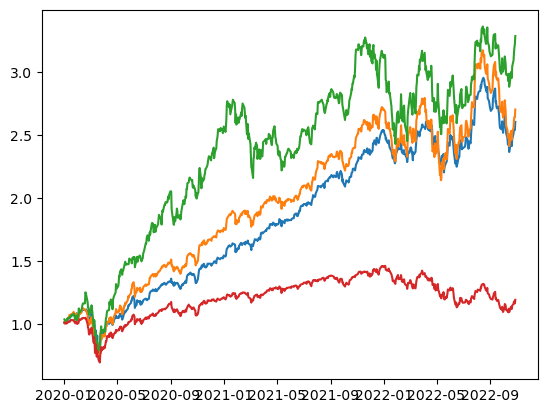

In [127]:
fg = __.loc[__['Method']== 'Sharpe',:].drop('Method', axis = 1)
plt.plot(fg)
plt.show()

In [160]:
melted = all_metr(aaa).reset_index().melt(id_vars=['index','Method'])
melted

,index,Method,variable,value
0,Markowitz,Sharpe,AVG_returns,0.001526
1,Sharpe,Sharpe,AVG_returns,0.001648
2,Tobin,Sharpe,AVG_returns,0.002016
3,Markowitz,Sortino,AVG_returns,0.001580
4,Sharpe,Sortino,AVG_returns,0.001661
...,...,...,...,...
79,Sharpe,P/S,Recovery(days),202.000000
80,Tobin,P/S,Recovery(days),204.000000
81,Markowitz,Alpha/Beta,Recovery(days),128.000000
82,Sharpe,Alpha/Beta,Recovery(days),139.000000


In [161]:
def get_slice(df_melted, method):
    for var in df_melted['variable'].unique():
        avg = df_melted.loc[df_melted['variable']==var]
        sex = avg.loc[avg['Method']==method].drop(['variable'],axis=1).set_index('index').T

        plt.bar(sex.columns, height=sex.iloc[1,:])
        plt.title(var)
        plt.show()    

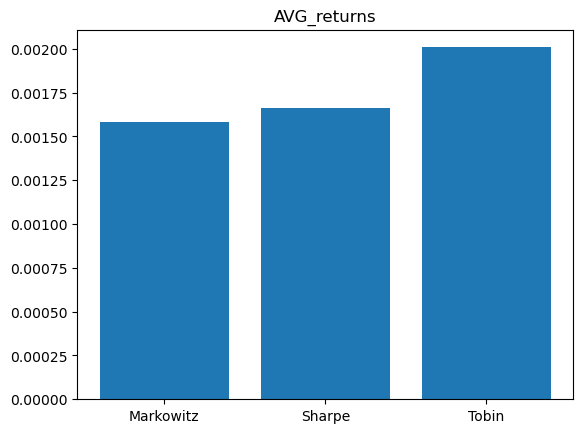

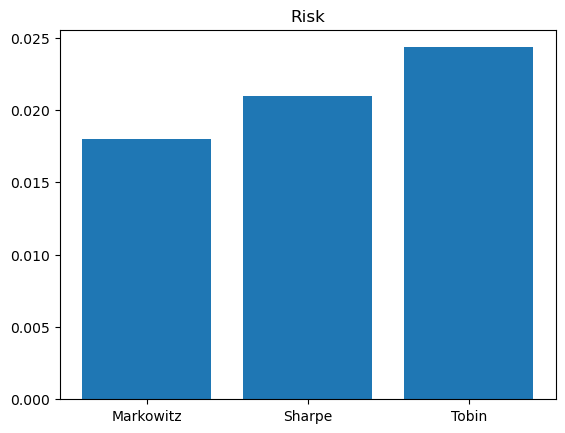

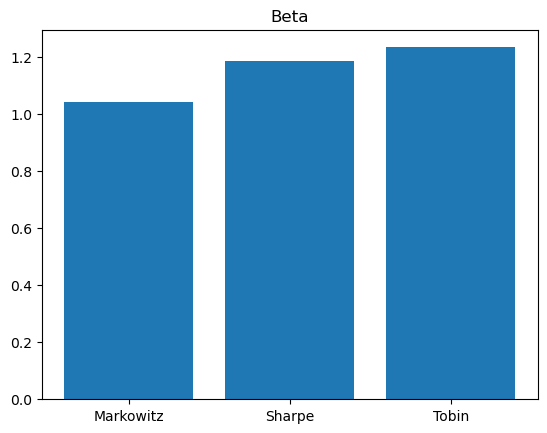

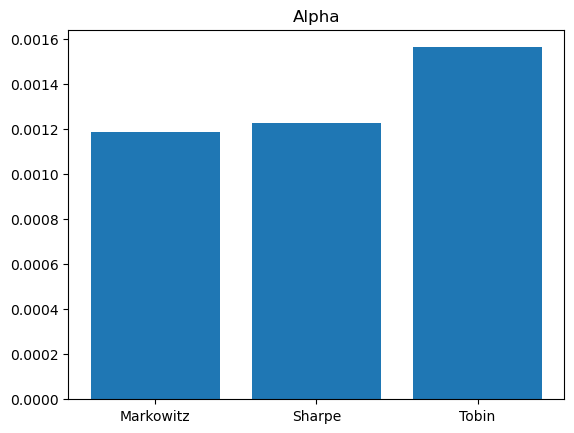

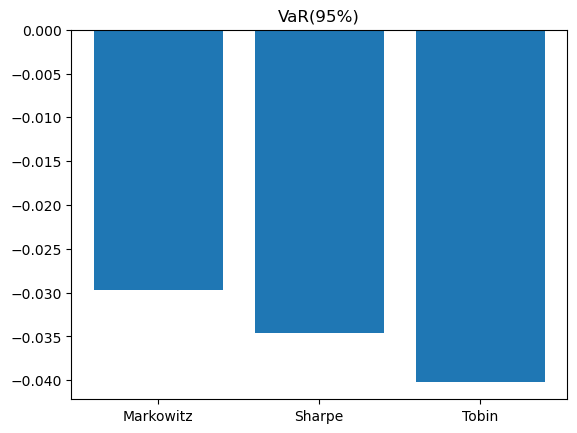

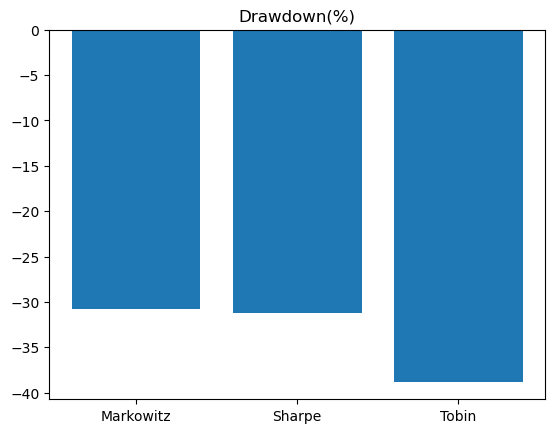

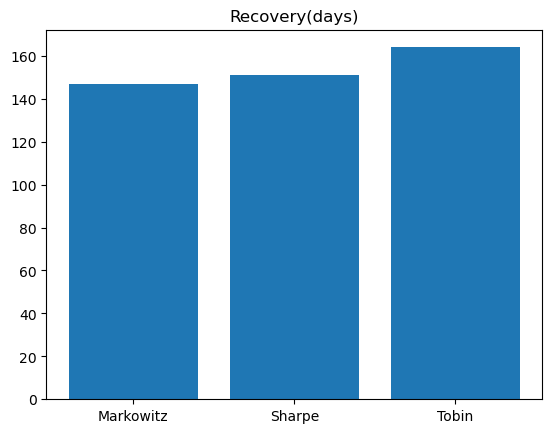

In [162]:
sd = get_slice(melted, 'Sortino')

In [132]:
avg = melted.loc[melted['variable']=='Risk']
sex = avg.loc[avg['Method']=='P/S'].drop(['variable'],axis=1).set_index('index').T
melted

# plt.bar(sex.columns, height=sex.iloc[1,:])
# plt.show()

,index,Method,variable,value
0,Markowitz,Sharpe,AVG_returns,0.001526
1,Sharpe,Sharpe,AVG_returns,0.001648
2,Tobin,Sharpe,AVG_returns,0.002016
3,Markowitz,Sortino,AVG_returns,0.001580
4,Sharpe,Sortino,AVG_returns,0.001661
...,...,...,...,...
79,Sharpe,P/S,Recovery(days),202.000000
80,Tobin,P/S,Recovery(days),204.000000
81,Markowitz,Alpha/Beta,Recovery(days),128.000000
82,Sharpe,Alpha/Beta,Recovery(days),139.000000


In [111]:
ss.to_excel('Data/assets.xlsx')